In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/new-york-city-airbnb-open-data/New_York_City_.png
/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv


In [2]:
import pandas_profiling
import plotly.graph_objs as go
import datetime as dt
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#Machine LEarning imports
import sklearn
from sklearn import preprocessing, model_selection, metrics 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [3]:
df = pd.read_csv('/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv')

In [4]:
#profile = pandas_profiling.ProfileReport(df)
#profile.to_file(output_file = "D:\Sailaja_16Mar19\Kaggle\AirBnB\profile_airbnb.html")

#profile


In [5]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


1. when number_of_reviews is NULL, it indicates that the related features, reviews_per_month and last_review are NULL as well. This means there aren't any reviews about the property yet. set these values to 0 (no reviews)
2. calculated_host_listings_count indicates the number of listings a host_id has.
3. Missing values need to be addressed. NULL in availability_365 indicates, that the listing is available all year through, update to 365

Let us try to find out -
1. Most listings from which neighbourhood/ area
2. Most popular listing - that has maximum reviews, maximum reviews per month indicates that the listing is frequently booked.
3. which listings are highly priced? Relation between price and area, relation between price and reviews, number of listings in specific price bands
4. which room type are popular, in which area

In [6]:
#set reviews_per_month to "0" where number_of_reviews is "0"
df.loc[(df['reviews_per_month'].isnull()) & (df['number_of_reviews'] == 0)]

df.loc[(df['reviews_per_month'].isnull()) & (df['number_of_reviews'] == 0), 'reviews_per_month'] = 0

In [7]:
df.loc[(df['number_of_reviews'] == 0) & (df['last_review'].isnull())]

#Lets not set the date to todays date for null values.
#df.loc[(df['number_of_reviews'] == 0) & (df['last_review'].isnull()), 'last_review'] = dt.datetime.today().strftime("%Y-%m-%d")

#Instead lets set the date to a past date
df.loc[(df['number_of_reviews'] == 0) & (df['last_review'].isnull()), 'last_review'] = pd.to_datetime('1900-01-01').strftime("%Y-%m-%d")


In [8]:
df['last_review'].max()
df['last_review'].min()

'1900-01-01'

In [9]:
df['availability_365'].unique()
df.loc[df['availability_365'].isnull()]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365


In [10]:
#Maximum number of listings in Manhattan, followed by Bronx.
#Least at Staten Island
temp = df.groupby(['neighbourhood_group']).count()['id'].reset_index().rename(columns={'neighbourhood_group': 'neighbourgrp', 'id':'count'})
temp

,neighbourgrp,count
0,Bronx,1091
1,Brooklyn,20104
2,Manhattan,21661
3,Queens,5666
4,Staten Island,373


In [11]:
temp = pd.crosstab(df['neighbourhood_group'], df['room_type'])

temp

room_type,Entire home/apt,Private room,Shared room
neighbourhood_group,,,
Bronx,379,652,60
Brooklyn,9559,10132,413
Manhattan,13199,7982,480
Queens,2096,3372,198
Staten Island,176,188,9


In [12]:
#fig = go.Figure(data = [go.Bar(y = temp['count'], x = temp['neighbourgrp'])],
#               layout_title_text = "Distribution of listings in the neighbourhood group")
#fig.update_xaxes(showgrid = True,
#                ticks = "outside",
#               tickson = "boundaries",
#                ticklen = 20)

#fig.show()


In [13]:
temp = df.groupby(['room_type']).count()['id'].reset_index().rename(columns={'room_type': 'room_type', 'id':'count'})
temp

,room_type,count
0,Entire home/apt,25409
1,Private room,22326
2,Shared room,1160


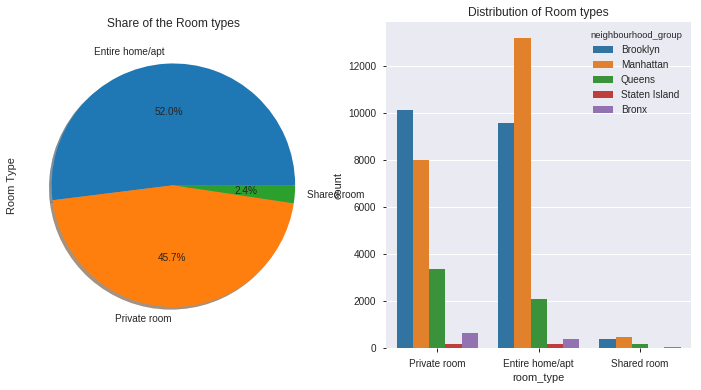

In [14]:
f, ax = plt.subplots(1,2,figsize = (12,6))
df['room_type'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Share of the Room types')
ax[0].set_ylabel ('Room Type')

sns.countplot('room_type', data=df, hue='neighbourhood_group', ax = ax[1])
ax[1].set_title ('Distribution of Room types')
plt.show()



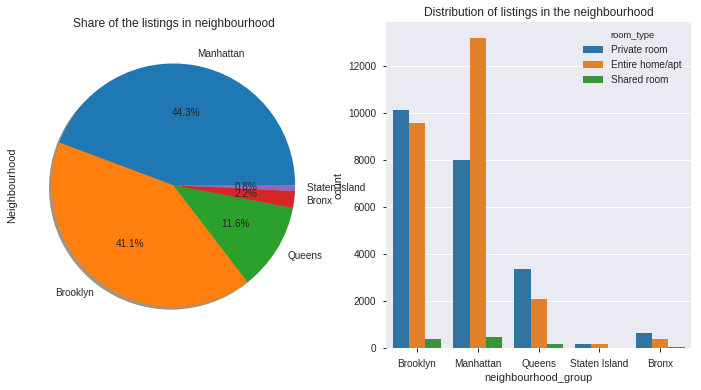

In [15]:
f, ax = plt.subplots(1,2,figsize = (12,6))
df['neighbourhood_group'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Share of the listings in neighbourhood')
ax[0].set_ylabel ('Neighbourhood')

sns.countplot('neighbourhood_group', data=df, hue='room_type', ax = ax[1])
ax[1].set_title ('Distribution of listings in the neighbourhood')
plt.show()

In [16]:
#Mostly the listings are Entire home or a Private room. Sahred rooms are least preferred.
fig = go.Figure(data = [go.Bar(y = temp['count'], x = temp['room_type'])],
               layout_title_text = "Distribution of listings based on room type")
fig.update_xaxes(showgrid = True,
                ticks = "outside",
                tickson = "boundaries",
                ticklen = 20)

fig.show()


In [17]:
df.corr().style.background_gradient()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,1,0.58829,-0.00312529,0.0909085,0.0106187,-0.0132245,-0.31976,0.180221,0.133272,0.0854676
host_id,0.58829,1,0.0202242,0.127055,0.0153091,-0.0173643,-0.140106,0.209783,0.15495,0.203492
latitude,-0.00312529,0.0202242,1,0.0847884,0.0339387,0.0248693,-0.0153888,-0.0187577,0.0195174,-0.0109835
longitude,0.0909085,0.127055,0.0847884,1,-0.150019,-0.0627471,0.0590943,0.138516,-0.114713,0.0827307
price,0.0106187,0.0153091,0.0339387,-0.150019,1,0.0427993,-0.0479542,-0.0505641,0.0574717,0.0818288
minimum_nights,-0.0132245,-0.0173643,0.0248693,-0.0627471,0.0427993,1,-0.0801161,-0.124905,0.12796,0.144303
number_of_reviews,-0.31976,-0.140106,-0.0153888,0.0590943,-0.0479542,-0.0801161,1,0.589407,-0.0723761,0.172028
reviews_per_month,0.180221,0.209783,-0.0187577,0.138516,-0.0505641,-0.124905,0.589407,1,-0.0473121,0.163732
calculated_host_listings_count,0.133272,0.15495,0.0195174,-0.114713,0.0574717,0.12796,-0.0723761,-0.0473121,1,0.225701
availability_365,0.0854676,0.203492,-0.0109835,0.0827307,0.0818288,0.144303,0.172028,0.163732,0.225701,1


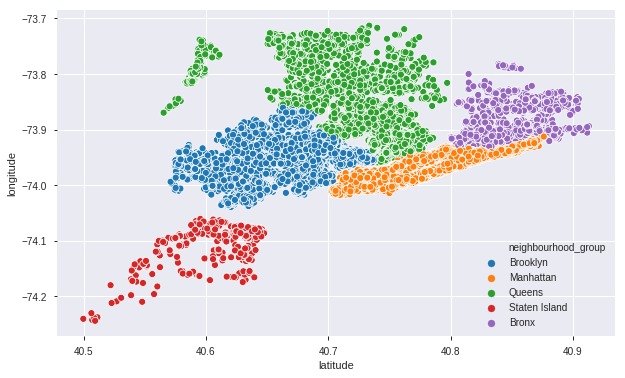

In [18]:
plt.figure(figsize = (10,6))
sns.scatterplot(y = df.longitude, x = df.latitude, hue=df.neighbourhood_group)

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



<Figure size 720x432 with 0 Axes>

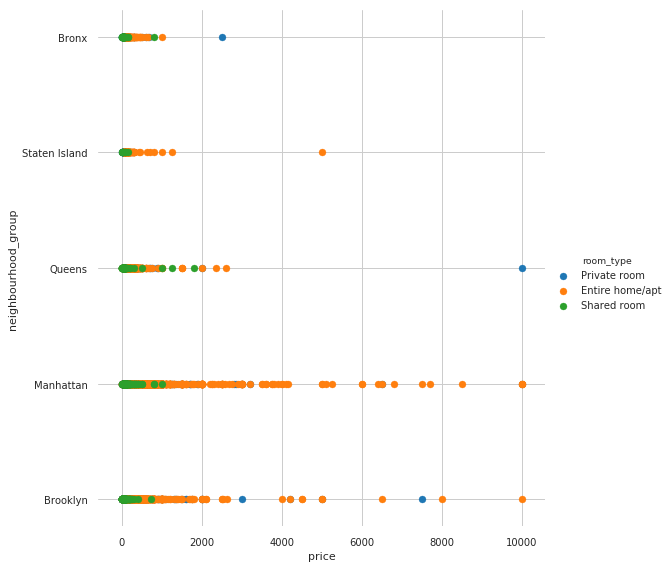

In [19]:
plt.figure(figsize=(10,6))
sns.set_style("whitegrid");
sns.FacetGrid(df,hue='room_type',size=8).map(plt.scatter,'price','neighbourhood_group').add_legend()
plt.ioff()
plt.show()

<Figure size 720x432 with 0 Axes>

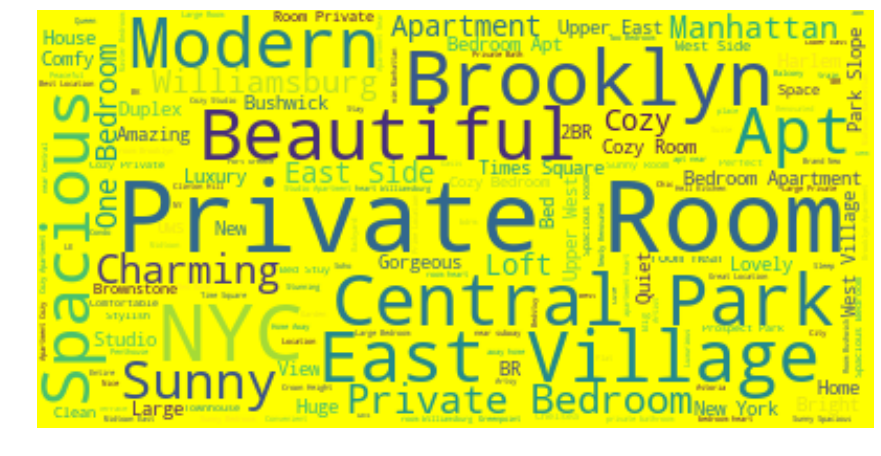

In [20]:
from wordcloud import WordCloud, ImageColorGenerator
text = " ".join(str(each) for each in df.name)
# Create and generate a word cloud image:
wordcloud = WordCloud(max_words=200, background_color="yellow").generate(text)
plt.figure(figsize=(10,6))
plt.figure(figsize=(15,10))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:
#scatterplot of Latitude and Longitude
fig = go.Figure(data = go.Scattergeo(locationmode = 'USA-states',
                                    lon = df['longitude'],
                                    lat = df['latitude'],
                                    mode = 'markers',
                                    marker = dict(
                                                size = 8,
                                                opacity = 0.8,
                                                reversescale = True,
                                                autocolorscale = False,
                                                symbol = 'square',
                                                line = dict(
                                                    width=1,
                                                    color='rgba(102, 102, 102)'
                                                ),
                                                colorscale = 'Blues',
                                                cmin = 0,
                                                color = df['price'],
                                                cmax = df['price'].max(),
                                                colorbar_title="Price of the listings in NYC"
                                            )))

fig.show()

In [22]:
'''Encode labels with value between 0 and n_classes-1.'''
le = preprocessing.LabelEncoder()                                            # Fit label encoder
le.fit(df['neighbourhood_group'])
df['neighbourhood_group']=le.transform(df['neighbourhood_group'])    # Transform labels to normalized encoding.

le = preprocessing.LabelEncoder()
le.fit(df['neighbourhood'])
df['neighbourhood']=le.transform(df['neighbourhood'])

le = preprocessing.LabelEncoder()
le.fit(df['room_type'])
df['room_type']=le.transform(df['room_type'])

df.sort_values(by='price',ascending=True,inplace=True)

df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
25796,20639914,Cozy yet spacious private brownstone bedroom,86327101,Adeyemi,1,13,40.68258,-73.91284,1,0,1,95,2019-06-23,4.35,6,222
25634,20523843,"MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)",15787004,Martial Loft,1,28,40.69467,-73.92433,1,0,2,16,2019-05-18,0.71,5,0
25433,20333471,★Hostel Style Room | Ideal Traveling Buddies★,131697576,Anisha,0,62,40.83296,-73.88668,1,0,2,55,2019-06-24,2.56,4,127
25753,20608117,"Sunny, Quiet Room in Greenpoint",1641537,Lauren,1,91,40.72462,-73.94072,1,0,2,12,2017-10-27,0.53,2,0
23161,18750597,"Huge Brooklyn Brownstone Living, Close to it all.",8993084,Kimberly,1,13,40.69023,-73.95428,1,0,4,1,2018-01-06,0.05,4,28


In [23]:
lr = LinearRegression()

X = df[['host_id','neighbourhood_group','neighbourhood','latitude','longitude','room_type','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)

#Lets analyse few metrics to see our predictoins
print("Mean Squared Error: {}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
       

Mean Squared Error: 180.7340965693623


In [24]:
y_predy_pred

NameError: name 'y_predy_pred' is not defined